This code takes mean sea level (MSL) data from two recording stations as csv files that can be obtained by the National Oceanic and Atmospheric Adminstration (NOAA) website. It performs graphical data analysis, data quality checking, calculates descriptive statistics and performs an ARIMA forecasting for both stations. Users download the csv files into the same directory as the code and input the name of the files to process data from the stations. 

In [1]:
#Importing Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from scipy import stats
import pmdarima as pm
import seaborn as sns
sns.set()

# Input files 

In [2]:
f1= input("Enter Station 1 file name: ") #Guam- 1630000_meantrend.csv
print('Your file: ' + f1)

Enter Station 1 file name: 1630000_meantrend.csv
Your file: 1630000_meantrend.csv


In [4]:
f2= input("Enter Station 2 file name: ") #Alaska- 9452210_meantrend.csv
print('Your file: ' + f2)

Enter Station 2 file name: 9452210_meantrend.csv
Your file: 9452210_meantrend.csv


# Station 1

## Graphical Data Analysis

In [5]:
#Reading and Displaying data
data1= pd.read_csv(f1, index_col=False)
data1

,Year,Month,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.
0,1948,1,-0.001,0.007,0.056,-0.043
1,1948,2,-0.019,0.006,0.056,-0.043
2,1948,3,-0.014,0.006,0.056,-0.043
3,1948,4,0.056,0.006,0.056,-0.043
4,1948,5,0.068,0.006,0.055,-0.043
...,...,...,...,...,...,...
847,2018,8,0.057,0.126,0.198,0.053
848,2018,9,0.054,0.126,0.199,0.053
849,2018,10,-0.026,0.126,0.200,0.053
850,2018,11,-0.055,0.126,0.200,0.052


In [6]:
#Creating time step for data 
tsgd = pd.date_range('1948 1', periods=data1.shape[0], freq='MS')

In [7]:
#Creating time series 
TSMSL = Series(data1.loc[:,' Monthly_MSL'].values, index=tsgd)

Text(0.5, 1.0, 'Monthly Mean Sea Level for Station 1')

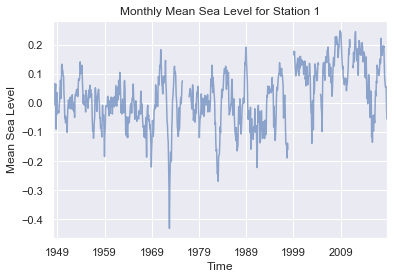

In [8]:
#Plotting time series object
ax= TSMSL.plot(alpha = .6)
ax.set_xlabel('Time')
ax.set_ylabel('Mean Sea Level')
ax.set_title('Monthly Mean Sea Level for Station 1')

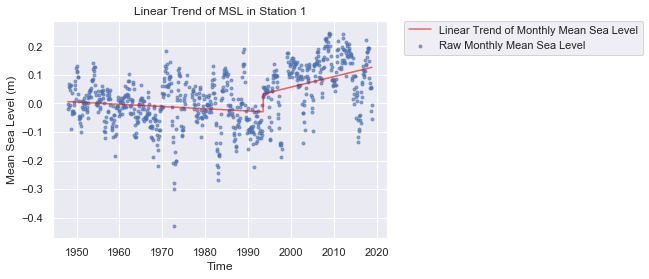

In [9]:
#Plotting Linear Trend and Raw Data Points 
plt.scatter(tsgd, data1[' Monthly_MSL'], marker='.', label= 'Raw Monthly Mean Sea Level', alpha = .6) #Plotting raw points as scatter
plt.plot(tsgd, data1[' Linear_Trend'], color= 'red', label= 'Linear Trend of Monthly Mean Sea Level', alpha = .6) #Plotting linear trend as line
plt.xlabel('Time')
plt.ylabel('Mean Sea Level (m)')
plt.title('Linear Trend of MSL in Station 1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


# Data Quality Checking 

In [10]:
#Function for reading data in from csv file 
def ReadData( fileName ):
    # define column names
    colNames = ['Year','Month','Monthly_MSL', 'Linear Trend','High_Conf.', 'Low_Conf.']

    # open and read the file
    DataDF = pd.read_csv(fileName,header=0, names=colNames)
    
    # define and initialize the missing data dictionary
    ReplacedValuesDF = pd.DataFrame(0, index=["1. No Data"], columns=colNames[1:])
     
    return( DataDF, ReplacedValuesDF )

#Function for removing No Data values:
def check1_removend(DataDF, ReplacedValuesDF):
    #Change counter
    nochg= DataDF.isna() 
    totalnochg= nochg.sum() 
    
    DataDF=DataDF.replace(r'^\s*$', -999, regex=True) #Sub whitespace cells as -999
    DataDF= DataDF.where(DataDF['Monthly_MSL']>-999) #Remove NA values (-999)
    
    #Counting NAs in dataframe per data type and saving to MissingValues
    ReplacedValuesDF.loc["1. No Data",:] = DataDF.isna().sum() - totalnochg

    return( DataDF, ReplacedValuesDF )

#Checking for range <1.7(https://tidesandcurrents.noaa.gov/est/faq.shtml)
def check2_removeouterrange(DataDF, ReplacedValuesDF):
    #Change counter
    nochg= DataDF.isna() 
    totalnochg= nochg.sum() 
    rangec = 0
    #Removing values greater than 1.7
    for x in DataDF.index:
        if ( DataDF.loc[x,"Monthly_MSL"]  > 1.7 ):
            DataDF.loc[x,"Monthly_MSL"] = np.NaN
            rangec = rangec + 1
    # count number of Nans per data type, and save to MissingValues
    ReplacedValuesDF.loc["2. Range Fail",:] = DataDF.isna().sum() - totalnochg

    return( DataDF, ReplacedValuesDF )

#Function for removing poor confidence:
def check3_poorconfidence(DataDF, ReplacedValuesDF):
    #Change counter
    nochg= DataDF.isna() 
    totalnochg= nochg.sum() 
    #adding confidence width column
    DataDF['Conf_Width'] = DataDF['High_Conf.']-DataDF['Low_Conf.']
    Q1 = DataDF['Conf_Width'].quantile(0.25)
    Q3 = DataDF['Conf_Width'].quantile(0.75)
    IQR = Q3-Q1
    #removing values with poor confidence
    DataDF.Conf_Width = DataDF.Conf_Width.where( np.logical_and(DataDF.Conf_Width > (Q1-1.5*IQR),
                                                            DataDF.Conf_Width < (Q3+1.5*IQR) ))
    #Counting NAs in dataframe per data type and saving to MissingValues
    ReplacedValuesDF.loc["3. Confidence Fail",:] = DataDF.isna().sum() - totalnochg
    return( DataDF, ReplacedValuesDF )            


Raw data.....
               Year      Month  Monthly_MSL  Linear Trend  High_Conf.  \
count   852.000000  852.00000   815.000000    852.000000  852.000000   
mean   1983.000000    6.50000     0.021298      0.021514    0.062496   
std      20.505939    3.45408     0.096398      0.047442    0.056101   
min    1948.000000    1.00000    -0.431000     -0.029000    0.012000   
25%    1965.000000    3.75000    -0.043000     -0.015000    0.016000   
50%    1983.000000    6.50000     0.018000     -0.001000    0.033000   
75%    2001.000000    9.25000     0.092500      0.061250    0.110000   
max    2018.000000   12.00000     0.248000      0.127000    0.201000   

        Low_Conf.  
count  852.000000  
mean    -0.019469  
std      0.040923  
min     -0.079000  
25%     -0.043000  
50%     -0.036000  
75%      0.014250  
max      0.055000  

Missing Values Removed.....
               Year       Month  Monthly_MSL  Linear Trend  High_Conf.  \
count   815.000000  815.000000   815.000000    815.0

,Year,Month,Monthly_MSL,Linear Trend,High_Conf.,Low_Conf.,Conf_Width
0,1948.0,1.0,-0.001,0.007,0.056,-0.043,0.099
1,1948.0,2.0,-0.019,0.006,0.056,-0.043,0.099
2,1948.0,3.0,-0.014,0.006,0.056,-0.043,0.099
3,1948.0,4.0,0.056,0.006,0.056,-0.043,0.099
4,1948.0,5.0,0.068,0.006,0.055,-0.043,0.098
...,...,...,...,...,...,...,...
847,2018.0,8.0,0.057,0.126,0.198,0.053,0.145
848,2018.0,9.0,0.054,0.126,0.199,0.053,NaN
849,2018.0,10.0,-0.026,0.126,0.200,0.053,NaN
850,2018.0,11.0,-0.055,0.126,0.200,0.052,NaN


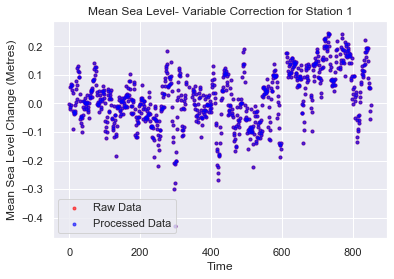

In [11]:
#Data Quality Check for Station 1


fileName = f1
DataDF, ReplacedValuesDF = ReadData(fileName)
    
print("\nRaw data.....\n", DataDF.describe())
    
DataDF, ReplacedValuesDF = check1_removend( DataDF, ReplacedValuesDF )
    
print("\nMissing Values Removed.....\n", DataDF.describe())
    
DataDF, ReplacedValuesDF = check2_removeouterrange( DataDF, ReplacedValuesDF )
    
print("\nCheck for MSL values in Range complete.....\n", DataDF.describe())
    
DataDF, ReplacedValuesDF = check3_poorconfidence(DataDF, ReplacedValuesDF)
    
print("\nConfidence width check complete.....\n", DataDF.describe())

print("\nAll processing finished.....\n", DataDF.describe())
print("\nFinal changed values counts.....\n", ReplacedValuesDF)
    
    
#Raw data Variables
Open= ReadData(f1)
RawData = Open[0]
    
#Plotting Raw and Processed Data 
plot1= plt.figure()
ax1= plot1.add_subplot(111)
ax1.scatter(x=RawData.index.values, y=RawData['Monthly_MSL'], marker='.', label="Raw Data", color = "red", alpha = .6)
ax1.scatter(x=DataDF.index.values, y=DataDF['Monthly_MSL'],  marker='.', label='Processed Data', color = "blue", alpha = .6)
plt.xlabel('Time')
plt.ylabel('Mean Sea Level Change (Metres)')
plt.title('Mean Sea Level- Variable Correction for Station 1')
plt.legend(loc = 'lower left')
DataDF1=DataDF
DataDF1

# Descriptive Statistics

In [12]:
DataDF1=DataDF1['Monthly_MSL'].dropna(axis=0)
DataDF1=pd.DataFrame(DataDF1, columns=['Monthly_MSL'])

median_stat1 = np.median(DataDF1['Monthly_MSL'])
median_greater3x1 = DataDF1[DataDF1['Monthly_MSL']>(2*median_stat1)]
median_month1=len(median_greater3x1)
medianpercent1=(median_month1/len(DataDF1['Monthly_MSL']))*100

mean_stat1 = np.mean(DataDF1['Monthly_MSL'])
mean_greater3x1 = DataDF1[DataDF1['Monthly_MSL']>(2*mean_stat1)]
meanmonth1=len(mean_greater3x1)
meanpercent1=(meanmonth1/len(DataDF1['Monthly_MSL']))*100

lowest_year1 = DataDF1['Monthly_MSL'].rolling(window=12).mean().min()

max1=DataDF1['Monthly_MSL'].max()
min1=DataDF1['Monthly_MSL'].min()

print("Station 1: maximum mean sea level is", max1)
print("Station 1: minimum mean sea level is", min1)
print("Station 1: average mean sea level is", mean_stat1)
print("Station 1: median mean sea level is", median_stat1)
print("Station 1: percent of months where mean sea level exceeds 2x the median is", medianpercent1,"%")
print("Station 1: percent of months where mean sea level exceeds 2x the mean is", meanpercent1,"%")
print("Station 1: lowest average mean sea level for 12 months is", lowest_year1)

Station 1: maximum mean sea level is 0.248
Station 1: minimum mean sea level is -0.431
Station 1: average mean sea level is 0.02129815950920246
Station 1: median mean sea level is 0.018000000000000002
Station 1: percent of months where mean sea level exceeds 2x the median is 42.331288343558285 %
Station 1: percent of months where mean sea level exceeds 2x the mean is 40.736196319018404 %
Station 1: lowest average mean sea level for 12 months is -0.20175


# ARIMA Model generation 

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-2857.405, BIC=-2838.592, Time=0.380 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-1497.141, BIC=-1487.735, Time=0.099 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-2857.800, BIC=-2843.691, Time=0.071 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-2151.865, BIC=-2137.756, Time=0.303 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=-1460.251, BIC=-1455.548, Time=0.042 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-2857.366, BIC=-2838.553, Time=0.135 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-2855.269, BIC=-2831.753, Time=0.176 seconds
Total fit time: 1.257 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  815
Model:               SARIMAX(1, 0, 0)   Log Likelihood              

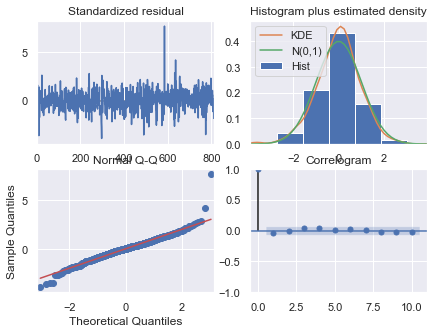

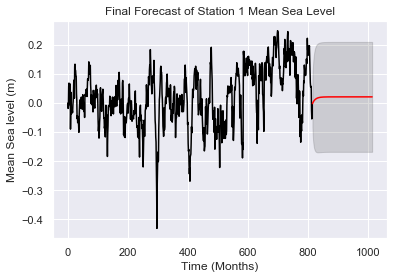

In [13]:
#Automated ARIMA- Station 1 
model1 = pm.auto_arima(DataDF1['Monthly_MSL'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model1.summary())
model1.plot_diagnostics(figsize=(7,5))
plt.show()

# Forecast
n_periods = 200
fc, confint = model1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(DataDF1['Monthly_MSL']), len(DataDF1['Monthly_MSL'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(range(0, len(DataDF1)), DataDF1['Monthly_MSL'], color='black')
plt.plot(fc_series, color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Station 1 Mean Sea Level")
plt.xlabel("Time (Months)")
plt.ylabel("Mean Sea level (m)")
plt.show()

# Station 2

## Graphical Data Analysis

In [14]:
#Reading and Displaying data
data2= pd.read_csv(f2, index_col=False)
data2

,Year,Month,Monthly_MSL,Unverified,Linear_Trend,High_Conf.,Low_Conf.,Unnamed: 7
0,1936,1,1.051,U,1.050,1.067,1.033,NaN
1,1936,2,0.916,U,1.049,1.066,1.032,NaN
2,1936,3,0.929,U,1.048,1.065,1.031,NaN
3,1936,4,0.963,U,1.047,1.063,1.030,NaN
4,1936,5,1.052,U,1.046,1.062,1.029,NaN
...,...,...,...,...,...,...,...,...
1004,2019,9,-0.111,NaN,-0.065,-0.049,-0.081,NaN
1005,2019,10,-0.213,NaN,-0.066,-0.050,-0.082,NaN
1006,2019,11,-0.205,NaN,-0.067,-0.051,-0.083,NaN
1007,2019,12,-0.004,NaN,-0.068,-0.052,-0.084,NaN


In [15]:
#Creating time step for data 
tsgd1 = pd.date_range('1936 1', periods=data2.shape[0], freq='MS')

In [16]:
#Creating time series 
TSMSL = Series(data2.loc[:,' Monthly_MSL'].values, index=tsgd1)

Text(0.5, 1.0, 'Monthly Mean Sea Level for Station 2')

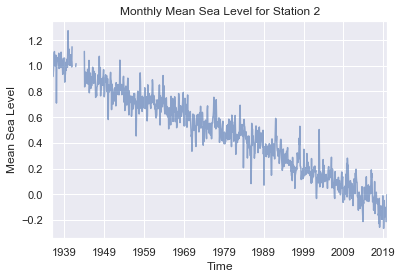

In [17]:
#Plotting time series object
ax= TSMSL.plot(alpha = .6)
ax.set_xlabel('Time')
ax.set_ylabel('Mean Sea Level')
ax.set_title('Monthly Mean Sea Level for Station 2')

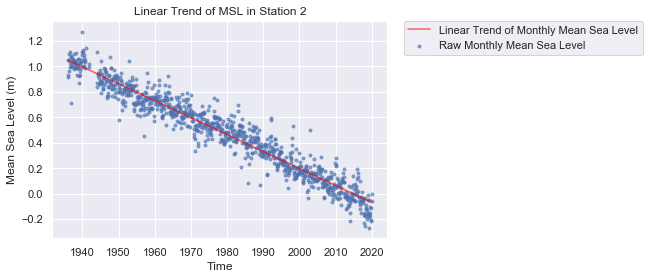

In [18]:
#Plotting linear Trend 
plt.scatter(tsgd1, data2[' Monthly_MSL'], marker='.', label= 'Raw Monthly Mean Sea Level', alpha = .6) #Plotting raw data points as scatter
plt.plot(tsgd1, data2[' Linear_Trend'], color= 'red', label= 'Linear Trend of Monthly Mean Sea Level', alpha = .6) #Plotting linear trend as line 
plt.xlabel('Time')
plt.ylabel('Mean Sea Level (m)')
plt.title('Linear Trend of MSL in Station 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Data Quality Checking


Raw data.....
              Year  Monthly_MSL  Linear Trend   High_Conf.  Low_Conf.
count  975.000000  1009.000000   1009.000000  1009.000000        0.0
mean     0.473618     0.490419      0.501672     0.479167        NaN
std      0.326961     0.323611      0.323878     0.323362        NaN
min     -0.266000    -0.069000     -0.053000    -0.085000        NaN
25%      0.191000     0.211000      0.221000     0.200000        NaN
50%      0.497000     0.490000      0.498000     0.482000        NaN
75%      0.732000     0.770000      0.781000     0.759000        NaN
max      1.273000     1.050000      1.067000     1.033000        NaN

Missing Values Removed.....
              Year  Monthly_MSL  Linear Trend   High_Conf.  Low_Conf.
count  975.000000  1009.000000   1009.000000  1009.000000        0.0
mean     0.473618     0.490419      0.501672     0.479167        NaN
std      0.326961     0.323611      0.323878     0.323362        NaN
min     -0.266000    -0.069000     -0.053000    -0.085000

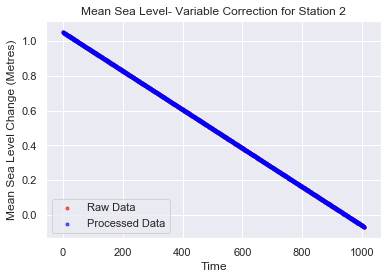

In [19]:
#Data Quality Check for Station 2


fileName = f2
DataDF, ReplacedValuesDF = ReadData(fileName)
    
print("\nRaw data.....\n", DataDF.describe())
      
DataDF, ReplacedValuesDF = check1_removend( DataDF, ReplacedValuesDF )
    
print("\nMissing Values Removed.....\n", DataDF.describe())
    
DataDF, ReplacedValuesDF = check2_removeouterrange( DataDF, ReplacedValuesDF )
    
print("\nCheck for MSL values in Range complete.....\n", DataDF.describe())
    
DataDF, ReplacedValuesDF = check3_poorconfidence(DataDF, ReplacedValuesDF)
    
print("\nConfidence width check complete.....\n", DataDF.describe())
    
print("\nAll processing finished.....\n", DataDF.describe())
print("\nFinal changed values counts.....\n", ReplacedValuesDF)
    
#Raw data Variables
Open= ReadData(f2)
RawData = Open[0]
    
#Plotting Raw and Processed Data 
plot2= plt.figure()
ax2= plot2.add_subplot(111)
ax2.scatter(x=range(0,len(RawData)), y=RawData['Monthly_MSL'], marker='.', label="Raw Data", color = "red", alpha = .6)
ax2.scatter(x=range(0,len(DataDF)), y=DataDF['Monthly_MSL'],  marker='.', label='Processed Data', color = "blue", alpha = .6)
plt.xlabel('Time')
plt.ylabel('Mean Sea Level Change (Metres)')
plt.title('Mean Sea Level- Variable Correction for Station 2')
plt.legend(loc = 'lower left')
DataDF2=DataDF

## Descriptive Statistics 

In [20]:
DataDF2=DataDF2['Monthly_MSL'].dropna(axis=0)
DataDF2=pd.DataFrame(DataDF2, columns=['Monthly_MSL'])

median_stat2 = np.median(DataDF2['Monthly_MSL'])
median_greater3x2 = DataDF2[DataDF2['Monthly_MSL']>(2*median_stat2)]
median_month2=len(median_greater3x2)
medianpercent2=(median_month2/len(DataDF2['Monthly_MSL']))*100

mean_stat2 = np.mean(DataDF2['Monthly_MSL'])
mean_greater3x2 = DataDF2[DataDF2['Monthly_MSL']>(2*mean_stat2)]
meanmonth2=len(mean_greater3x2)
meanpercent2 = (meanmonth2/len(DataDF2['Monthly_MSL']))*100

lowest_year2 = DataDF2['Monthly_MSL'].rolling(window=12).mean().min()

max2=DataDF2['Monthly_MSL'].max()
min2=DataDF2['Monthly_MSL'].min()

print("Station 2: maximum mean sea level is", max2)
print("Station 2: minimum mean sea level is", min2)
print("Station 2: average mean sea level is", mean_stat2)
print("Station 2: median mean sea level is", median_stat2)
print("Station 2: percent of months where mean sea level exceeds 2x the median is", medianpercent2,"%")
print("Station 2: percent of months where mean sea level exceeds 2x the mean is", meanpercent2,"%")
print("Station 2: lowest average mean sea level for 12 months is", lowest_year2)

Station 2: maximum mean sea level is 1.05
Station 2: minimum mean sea level is -0.069
Station 2: average mean sea level is 0.49041922695738355
Station 2: median mean sea level is 0.49
Station 2: percent of months where mean sea level exceeds 2x the median is 6.2438057482656095 %
Station 2: percent of months where mean sea level exceeds 2x the mean is 6.2438057482656095 %
Station 2: lowest average mean sea level for 12 months is -0.06308333333333427


## ARIMA Model Generation

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-10298.537, BIC=-10278.870, Time=1.664 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=589.683, BIC=599.517, Time=0.116 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=-10751.700, BIC=-10736.950, Time=0.760 seconds
Near non-invertible roots for order (1, 0, 0)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-797.145, BIC=-782.395, Time=0.672 seconds
Near non-invertible roots for order (0, 0, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=1792.013, BIC=1796.930, Time=0.039 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=-11693.275, BIC=-11668.691, Time=1.413 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constan

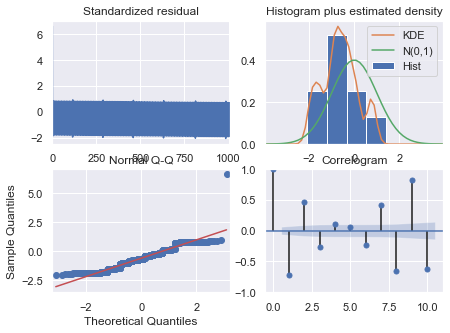

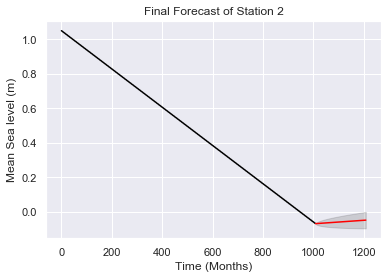

In [21]:
#Automated ARIMA- Station 2 
model2 = pm.auto_arima(DataDF2['Monthly_MSL'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())
model2.plot_diagnostics(figsize=(7,5))
plt.show()

# Forecast
n_periods = 200
fc, confint = model2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(DataDF2['Monthly_MSL']), len(DataDF2['Monthly_MSL'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(range(0, len(DataDF2)), DataDF2['Monthly_MSL'], color='black')
plt.plot(fc_series, color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Station 2")
plt.xlabel("Time (Months)")
plt.ylabel("Mean Sea level (m)")
plt.show()

# Descriptive stats graphs- Comparing the two stations

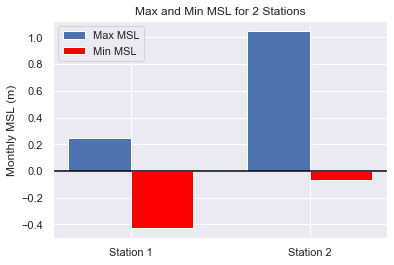

In [22]:
#Plotting Max and min 
labels= ['Station 1', 'Station 2']
maxs= [max1, max2]
mins= [min1, min2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, maxs, width, label='Max MSL')
rects2 = ax.bar(x + width/2, mins, width, label='Min MSL', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Monthly MSL (m)')
ax.set_title('Max and Min MSL for 2 Stations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black')
ax.legend()

plt.show()

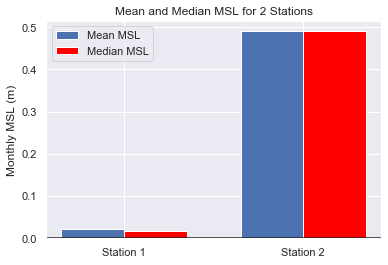

In [23]:
#Plotting mean and median  
labels= ['Station 1', 'Station 2']
means= [mean_stat1, mean_stat2]
medians= [median_stat1, median_stat2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means, width, label='Mean MSL')
rects2 = ax.bar(x + width/2, medians, width, label='Median MSL', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Monthly MSL (m)')
ax.set_title('Mean and Median MSL for 2 Stations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black')
ax.legend()

plt.show()

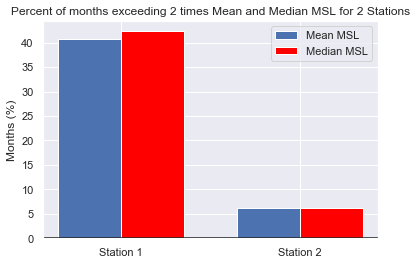

In [24]:
#Plotting percent months exceeding mean2x and median2x
labels= ['Station 1', 'Station 2']
meanmonths= [meanpercent1, meanpercent2]
medianmonths= [medianpercent1, medianpercent2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, meanmonths, width, label='Mean MSL')
rects2 = ax.bar(x + width/2, medianmonths, width, label='Median MSL', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Months (%)')
ax.set_title('Percent of months exceeding 2 times Mean and Median MSL for 2 Stations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black')
ax.legend()

plt.show()

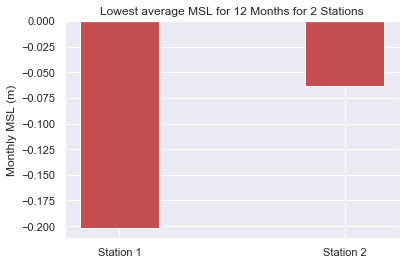

In [25]:
#Plotting lowest MSL
labels= ['Station 1', 'Station 2']
lowest= [lowest_year1, lowest_year2]
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(labels, lowest, width, color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Monthly MSL (m)')
ax.set_title('Lowest average MSL for 12 Months for 2 Stations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.axhline(y=0, color='black')

plt.show()